In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import svm
from sklearn.externals import joblib

import src.misc.paths as path
import src.vector_gen.generateWeatherVectors as gwv

%matplotlib inline

training_files = "../../dataset/training/"
trajectories_file = "trajectories(table 5)_training.csv"
trajectories_df = pd.read_csv(training_files+trajectories_file)

# prepare data

In [2]:
x, y = gwv.generate_timeInformationVectors(trajectories_df)

x_df = gwv.generate_timeInformationVectorX_df(trajectories_df, True)# using arrays -.-
#x_df =  pd.DataFrame(np.reshape(x,(len(x)/3,3)), columns=['dayofweek', 'hour', 'minute'])



y_df = pd.DataFrame(y, columns=['avg_travel_time'])


In [3]:
x

array([ 1,  0,  0, ...,  0, 21, 40], dtype=int64)

In [4]:
x_df['date'] = x_df['datetime'].dt.date
x_df = x_df.set_index(['date','hour','minute'])
x_df.head()

datetime  dayofweek
date       hour minute                               
2016-07-19 0    0      2016-07-19 00:00:00          1
                20     2016-07-19 00:20:00          1
                40     2016-07-19 00:40:00          1
           1    0      2016-07-19 01:00:00          1
                20     2016-07-19 01:20:00          1

In [5]:
import itertools

t0 = list(x_df['datetime'])

route_touples = [('A', 2), ('A', 3), ('B', 1), ('B', 3), ('C', 1), ('C', 3)]

index_touples = list(itertools.product(t0, route_touples))
index_touples

# fix
res = []
for z in t0:
    for i_route, route in enumerate(route_touples):
        tmp = []
        tmp.append(z)
        tmp.append(route[0])
        tmp.append(route[1])
        tmp.append(i_route)
        res.append(tmp)
res[:10]

[[Timestamp('2016-07-19 00:00:00'), 'A', 2, 0],
 [Timestamp('2016-07-19 00:00:00'), 'A', 3, 1],
 [Timestamp('2016-07-19 00:00:00'), 'B', 1, 2],
 [Timestamp('2016-07-19 00:00:00'), 'B', 3, 3],
 [Timestamp('2016-07-19 00:00:00'), 'C', 1, 4],
 [Timestamp('2016-07-19 00:00:00'), 'C', 3, 5],
 [Timestamp('2016-07-19 00:20:00'), 'A', 2, 0],
 [Timestamp('2016-07-19 00:20:00'), 'A', 3, 1],
 [Timestamp('2016-07-19 00:20:00'), 'B', 1, 2],
 [Timestamp('2016-07-19 00:20:00'), 'B', 3, 3]]

In [6]:
#df2 =pd.DataFrame(x.reshape((len(x)/3,3)), columns=feature_cols)

df = pd.DataFrame(res, columns=['datetime', 'intersection_id', 'tollgate_id', 'route'])
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['dayofweek'] = df['datetime'].dt.dayofweek


df = df.join(y_df)
df.head()

,datetime,intersection_id,tollgate_id,route,date,hour,minute,dayofweek,avg_travel_time
0,2016-07-19,A,2,0,2016-07-19,0,0,1,37.09
1,2016-07-19,A,3,1,2016-07-19,0,0,1,35.27
2,2016-07-19,B,1,2,2016-07-19,0,0,1,15.58
3,2016-07-19,B,3,3,2016-07-19,0,0,1,67.81
4,2016-07-19,C,1,4,2016-07-19,0,0,1,8.36


In [7]:
y

array([ 37.09,  35.27,  15.58, ...,  39.47,  35.92,  21.77])

In [8]:
y_df.head()

,avg_travel_time
0,37.09
1,35.27
2,15.58
3,67.81
4,8.36


In [9]:
df['hour_index'] = df['hour']
df['minute_index'] = df['minute']
df = df.set_index(['date', 'hour_index', 'minute_index'])


In [10]:
df[['intersection_id', 'tollgate_id', 'route', 'hour', 'minute', 'dayofweek', 'avg_travel_time']].head(10)

intersection_id  tollgate_id  route  hour  \
date       hour_index minute_index                                             
2016-07-19 0          0                          A            2      0     0   
                      0                          A            3      1     0   
                      0                          B            1      2     0   
                      0                          B            3      3     0   
                      0                          C            1      4     0   
                      0                          C            3      5     0   
                      20                         A            2      0     0   
                      20                         A            3      1     0   
                      20                         B            1      2     0   
                      20                         B            3      3     0   

                                    minute  dayofweek  avg_travel_time  
date       hour_index minute_index                                      
2016-07-19 0          0                  0          1            37.09  
                      0                  0          1            35.27  
                      0                  0          1            15.58  
                      0                  0          1            67.81  
                      0                  0          1             8.36  
                      0                  0          1            17.12  
                      20                20          1            42.64  
                      20                20          1            77.61  
                      20                20          1            10.38  
                      20                20          1            25.51

# Feature Selection

In [11]:
feature_cols = ['route', 'hour', 'minute', 'dayofweek']
predict_cols = ['avg_travel_time']
#feature_cols = ['hour', 'minute', 'dayofweek']

tmp_all_cols = feature_cols.copy()
tmp_all_cols.extend(predict_cols)
df.reset_index()[tmp_all_cols].head(10)


,route,hour,minute,dayofweek,avg_travel_time
0,0,0,0,1,37.09
1,1,0,0,1,35.27
2,2,0,0,1,15.58
3,3,0,0,1,67.81
4,4,0,0,1,8.36
5,5,0,0,1,17.12
6,0,0,20,1,42.64
7,1,0,20,1,77.61
8,2,0,20,1,10.38
9,3,0,20,1,25.51


# split train and test

In [12]:
#from sklearn.model_selection import train_test_split

# not working!?!?!
import src.misc.split_train_valid as split
#training, validation, testing = split.split_dataset(x_df, 0.8, 0)

#x_train, x_test, y_train, y_test = train_test_split(df[feature_cols], df['avg_travel_time'], test_size=0.2, random_state=42)

# k-fold cross validation
# 13 weeks

# by hand?
# 91 days -> 13 weeks 
# 8 weeks to train
num_weeks_train = (7*24*3*6) * 8

x_train = df[feature_cols][:num_weeks_train]
x_test = df[feature_cols][num_weeks_train:]
y_train = df['avg_travel_time'][:num_weeks_train]
y_test = df['avg_travel_time'][num_weeks_train:]

# Support Vector Regression

## train model

In [13]:
%%time
# load
#svr_rbf = joblib.load('svr_rbf.pkl')

# train
svr_rbf = svm.SVR(kernel='rbf', cache_size=2000, epsilon=0.5, C=100.0)
svr_rbf.fit(x_train, y_train)
print(svr_rbf)

SVR(C=100.0, cache_size=2000, coef0=0.0, degree=3, epsilon=0.5, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Wall time: 5min 3s


In [ ]:
# no reasonable result
#%%time
#svr_sigmoid = svm.SVR(kernel='sigmoid', cache_size=6000)
#svr_sigmoid.fit(x_train, y_train)
#print(svr_sigmoid)

SVR(C=1.0, cache_size=6000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Wall time: 23.8 s


In [16]:
%%time
# load
svr_lin = joblib.load('svr_lin.pkl') 

# train
#svr_lin = svm.SVR(kernel='linear', cache_size=6000) 
#svr_lin.fit(x_train, y_train)
print(svr_lin)

SVR(C=1.0, cache_size=6000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Wall time: 14 ms


In [ ]:
# takes 4 ever!
#%%time
#svr_poly = svm.SVR(kernel='poly', cache_size=6000)
#svr_poly.fit(x_train, y_train)
#print(svr_poly)

## save models

In [14]:
from sklearn.externals import joblib
joblib.dump(svr_rbf, 'svr_rbf.pkl')
#joblib.dump(svr_sigmoid, 'svr_sigmoid.pkl')
joblib.dump(svr_lin, 'svr_lin.pkl')
#joblib.dump(svr_poly, 'svr_poly.pkl')

['svr_rbf.pkl']

# evaluate

In [17]:
y_pred_rbf = svr_rbf.predict(x_test)
#y_pred_sigmoid = svr_sigmoid.predict(x_test)
y_pred_lin = svr_lin.predict(x_test)
#y_pred_poly = svr_poly.predict(x_test)


In [18]:
res = pd.DataFrame(data= {'y_test':np.array(y_test), 
                          'y_pred_rbf':y_pred_rbf, 
#                          'y_pred_sigmoid':y_pred_sigmoid, 
                          'y_pred_lin':y_pred_lin, 
#                          'y_pred_poly':y_pred_poly
                         })
#res

In [19]:
res = res.copy()

# train by route?
#select_route = 3
#res = res.copy().loc[range(select_route,len(res),6)].reset_index(drop=True)

# hours
#res = res.copy().loc[:2*3*6].reset_index(drop=True)
res.head(7)

,y_pred_lin,y_pred_rbf,y_test
0,66.612275,42.219713,37.09
1,75.848984,35.770000,35.27
2,85.085693,16.080336,170.72
3,94.322401,29.239904,81.43
4,103.559110,8.134883,8.36
5,112.795819,17.619958,17.12
6,65.893111,41.086895,109.54


In [21]:
from sklearn import metrics
import src.misc.evaluation as evaluation_mape


print('sklearn mean_squared_error:')
print('y_pred_rbf:', metrics.mean_squared_error(res['y_pred_rbf'], res['y_test']))
#print('y_pred_sigmoid', metrics.mean_squared_error(res['y_pred_sigmoid'], res['y_test']))
print('y_pred_lin:', metrics.mean_squared_error(res['y_pred_lin'], res['y_test']))

print('')
print ('sklearn mean_absolute_error')
print('y_pred_rbf:', metrics.mean_absolute_error(res['y_pred_rbf'], res['y_test']))
print('y_pred_lin:', metrics.mean_absolute_error(res['y_pred_lin'], res['y_test']))

print('')
print('mape(mean_absolute_error):')
print('lower is better, 2havg submission had 0.2116 and rank 141')
print('y_pred_rbf:', evaluation_mape.mape(res['y_pred_rbf'], res['y_test']))
print('y_pred_lin:', evaluation_mape.mape(res['y_pred_lin'], res['y_test']))

sklearn mean_squared_error:
y_pred_rbf: 3370.61172733
y_pred_lin: 4401.95861424

sklearn mean_absolute_error
y_pred_rbf: 30.4489071327
y_pred_lin: 45.8363471679

mape(mean_absolute_error):
lower is better, 2havg submission had 0.2116 and rank 141
y_pred_rbf: 0.22789542462941537
y_pred_lin: 0.9656076445813447


'\nI also want to share my recent results. Maybe it helps or inspire someone.\n\nSVN on TimeInformation with rbf and linear kernel.\nTrained on the first 8 weeks and tested with the remaining data. (not shuffled)\n\n'

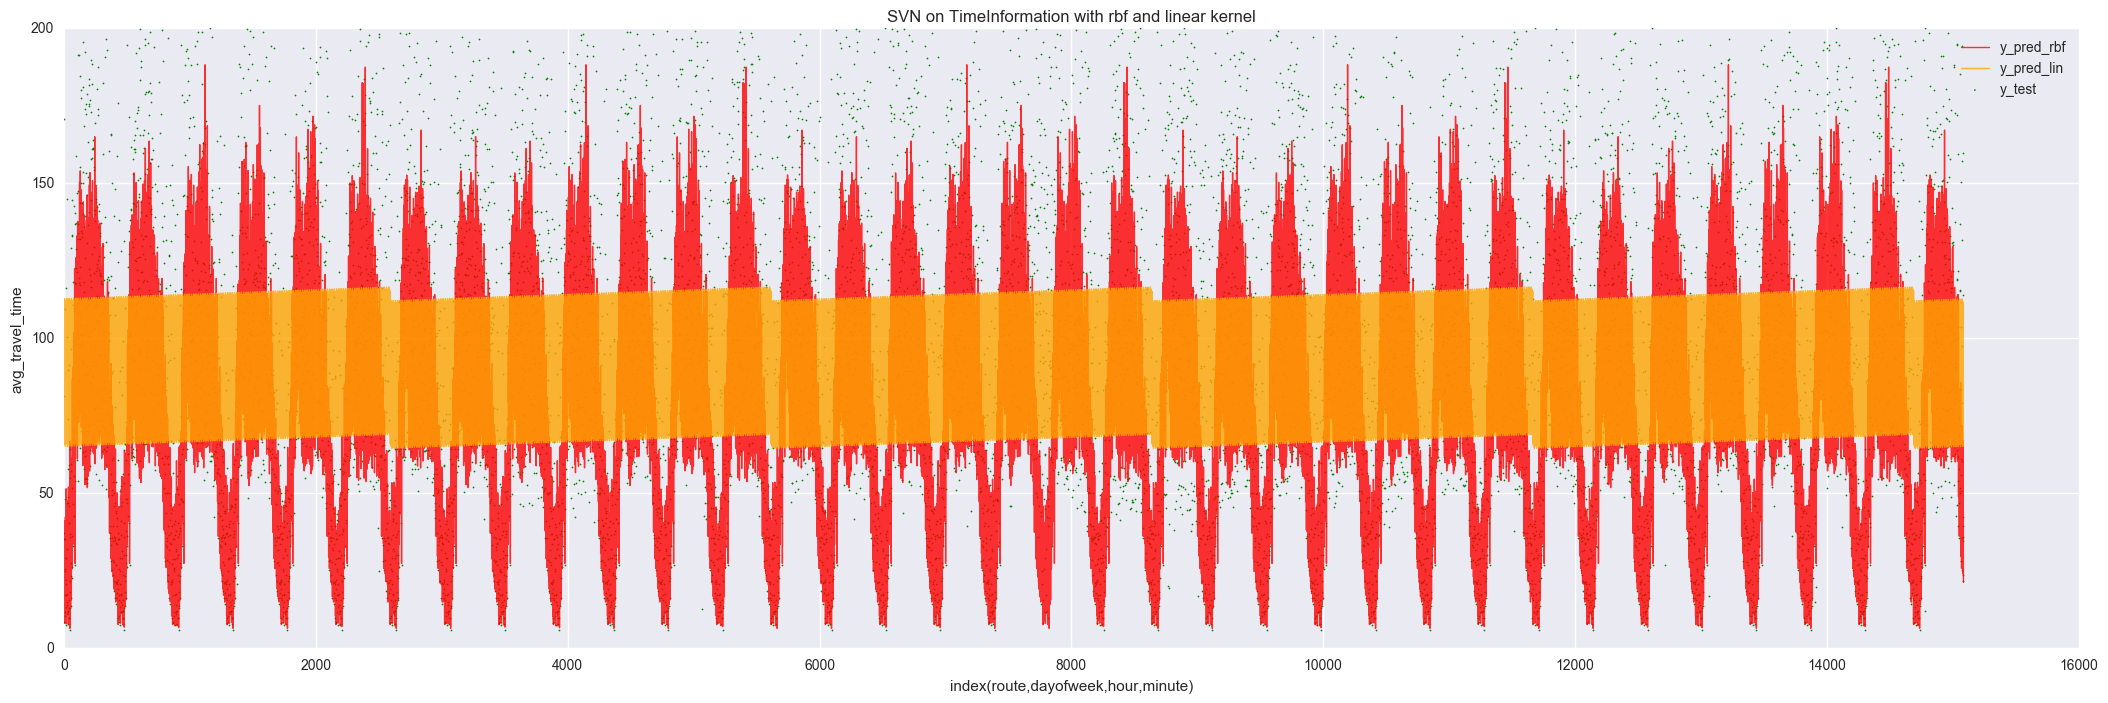

In [22]:
import matplotlib.pyplot as plt
alpha=0.8
lw=0.7

fig, ax = plt.subplots(figsize = (26,8))

ax.scatter(res.index.values, res['y_test'], color='green', label='y_test', s=0.8)

ax.plot(res.index.values, res['y_pred_rbf'], color='red', label='y_pred_rbf', alpha=alpha, lw=lw)
#plt.plot(res.index.values, res['y_pred_sigmoid'], color='blue', label='y_pred_sigmoid', alpha=alpha, lw=lw)
ax.plot(res.index.values, res['y_pred_lin'], color='orange', label='y_pred_lin', alpha=alpha, lw=lw)
#plt.plot(res.index.values, res['y_pred'], color='darkorange', label='y_pred_rbf')
ax.set_title('SVN on TimeInformation with rbf and linear kernel')
ax.set_xlabel('index(route,dayofweek,hour,minute)')
ax.set_ylabel('avg_travel_time')
ax.set_ylim(0,200)
ax.set_xlim(0)

ax.legend(shadow=True, fancybox=True)

#fig.legend()

'''
I also want to share my recent results. Maybe it helps or inspire someone.

SVN on TimeInformation with rbf and linear kernel.
Trained on the first 8 weeks and tested with the remaining data. (not shuffled)

'''


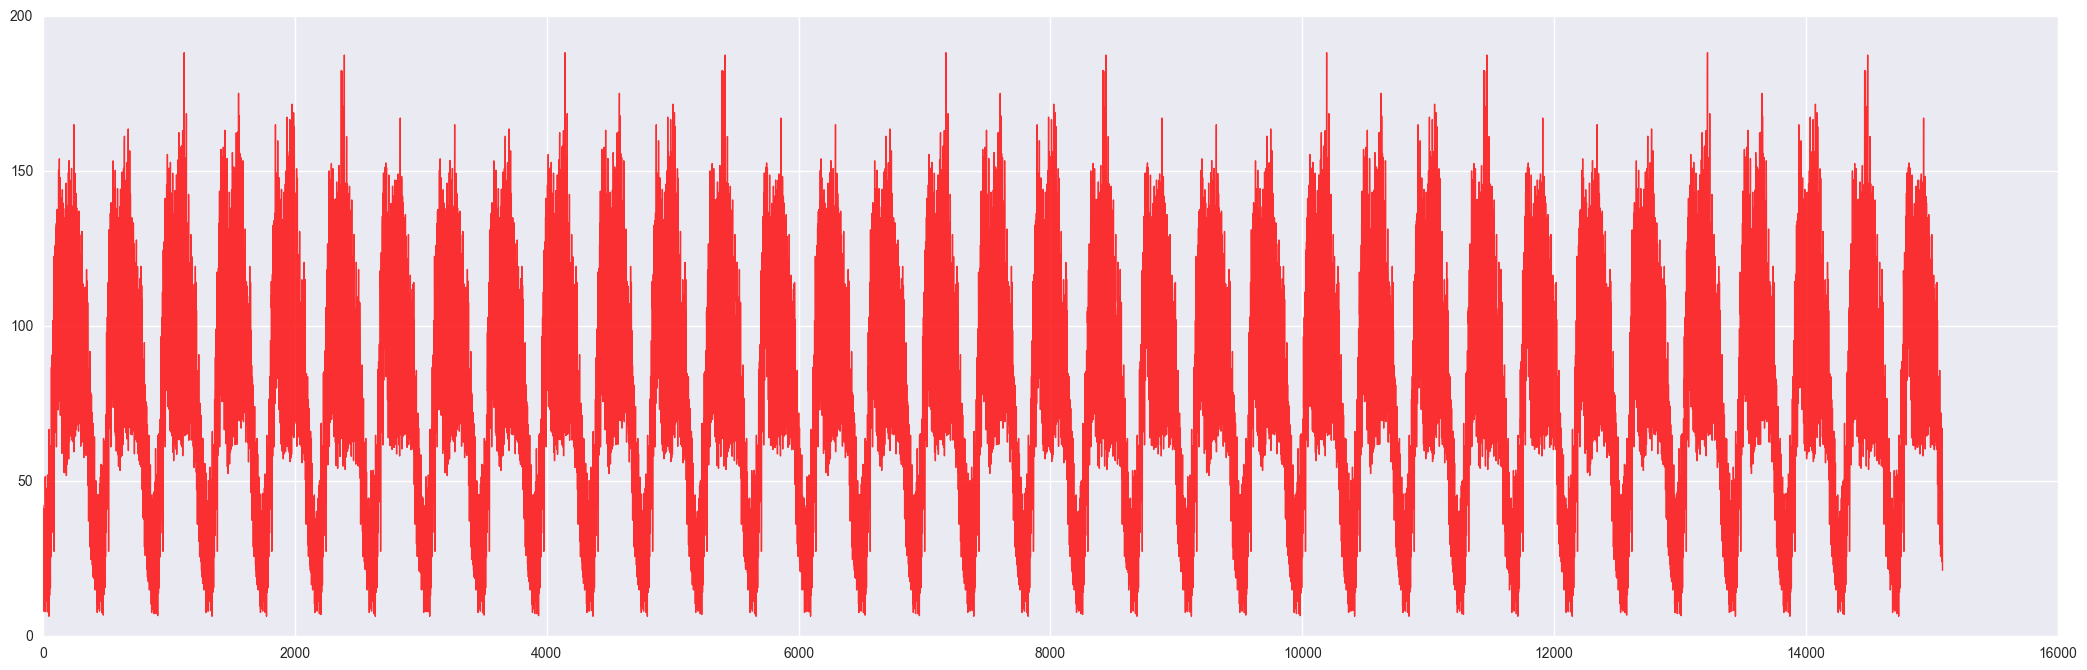

In [23]:
fig, ax = plt.subplots(figsize = (26,8))
ax.plot(res.index.values, res['y_pred_rbf'], color='red', label='y_pred_rbf', alpha=alpha, lw=lw)

# SVN Parameter Finding

In [ ]:
from sklearn.model_selection import GridSearchCV


svr = GridSearchCV(svm.SVR(kernel='rbf', cache_size=3000),
                           param_grid={"epsilon": [0.1],
                                       "C": [ 150, 175, 200]},
                  n_jobs=4)

svr.fit(x_train, y_train)



#, epsilon=0.5, C=100.0)
#svr_rbf.fit(x_train, y_train))

In [103]:
print(svr.best_estimator_)
print(svr.best_params_)
pd.DataFrame(svr.cv_results_).sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_epsilon,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,36.622666,3.669244,0.276397,0.285084,1,0.1,"{'epsilon': 0.1, 'C': 1}",10,0.200805,0.293995,0.374994,0.251222,0.253393,0.310034,0.288198,0.024328,0.072949,0.024823
1,35.813725,3.627138,0.276508,0.285209,1,0.3,"{'epsilon': 0.3, 'C': 1}",9,0.201143,0.294229,0.375102,0.251388,0.253277,0.310012,0.234229,0.004843,0.072893,0.024768
2,37.372794,3.609712,0.319274,0.334409,5,0.1,"{'epsilon': 0.1, 'C': 5}",8,0.245584,0.340597,0.418930,0.297602,0.293307,0.365029,0.163766,0.008182,0.073111,0.027872
3,37.534602,3.620907,0.319485,0.334584,5,0.3,"{'epsilon': 0.3, 'C': 5}",7,0.245926,0.340811,0.419071,0.297723,0.293457,0.365219,0.348919,0.010556,0.073043,0.027905
4,40.427018,3.592067,0.332573,0.350839,10,0.1,"{'epsilon': 0.1, 'C': 10}",6,0.258641,0.356085,0.432534,0.313794,0.306543,0.382636,0.670907,0.007156,0.073339,0.028348
5,39.692204,3.583895,0.332717,0.351093,10,0.3,"{'epsilon': 0.3, 'C': 10}",5,0.258689,0.356298,0.432695,0.314042,0.306765,0.382938,0.549525,0.017669,0.073369,0.028366
6,48.989573,3.609716,0.341044,0.363558,20,0.1,"{'epsilon': 0.1, 'C': 20}",4,0.266183,0.368336,0.441612,0.326705,0.315336,0.395631,1.233448,0.015112,0.073890,0.028341
7,45.042023,3.550385,0.341161,0.363807,20,0.3,"{'epsilon': 0.3, 'C': 20}",3,0.266117,0.368406,0.441850,0.327031,0.315515,0.395985,0.719901,0.019202,0.073999,0.028338
8,72.405444,3.583239,0.344864,0.371263,40,0.1,"{'epsilon': 0.1, 'C': 40}",2,0.268805,0.374303,0.448803,0.335832,0.316983,0.403656,6.819307,0.020033,0.076083,0.027772
9,65.253685,3.527888,0.345108,0.371622,40,0.3,"{'epsilon': 0.3, 'C': 40}",1,0.269005,0.374610,0.449078,0.336131,0.317240,0.404126,4.775460,0.027703,0.076110,0.027839
